# Is the optimal SVGD bandwidth roughly equal the KSD bandwidth?

Say you run SVGD using an RBF kernel with bandwidth $h$ and target distribution $p$. Then you're minimizing the kernelized Stein discrepancy between $q$ and $p$.

Now, let $q$ be the distribution of the particles at the end of SVGD. Choose some kernel $h_{KSD}$ and compute $D_{KSD}(q, p)$. Intuitively, this value should be smallest when $h_{KSD} = h$. In this notebook, I want to check this is actually the case.

Spoiler: it isn't.

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, jacfwd, jacrev
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

from svgd import SVGD
from metrics import ksd
import time
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

cpu


/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
n=100
d=1
stepsize = 0.01
n_iter_max = 500 # 100 slightly to little, this should be all right
# grid_length = 25
bandwidth = 1

from jax.scipy.stats import norm

@jit
def logp(x):
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1)) 

from svgd import get_bandwidth

svgd_fix = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWar

# Define optimizer and utilities

In [3]:
svgd_stepsize = stepsize
ksd_grid = [0.4, 1, 3, 5, 50, 100]


def get_metrics(rkey, h):
    xout, _ = svgd_fix.svgd(rkey, svgd_stepsize, h, n_iter_max)
    return [ksd(xout, logp, h) for h in ksd_grid]

def sweep(rkey, grid, average_over=1):
    """Sweep a grid of bandwidth values and output corresponding metrics.
    Arguments:
    * average_over: integer, compute average over m random seeds
    * 
    """
    if average_over == 1:
        sweep_results = []

        for h in tqdm(grid):
            l = get_metrics(rkey, h)
            sweep_results.append(l)
        sweep_results = np.array(sweep_results)
    else:
        ress = []
        for _ in range(average_over):
            rkey = random.split(rkey)[0]
            res = sweep(rkey, grid, sample_each_time=False, joint_param=joint_param, average_over=1)
            ress.append(res)
        ress = np.array(ress)
        sweep_results = np.mean(ress, axis=0)
    if np.any(np.isnan(sweep_results)): print("NaNs detected!")
    return sweep_results

def get_ksd_ada(m, ksd_bandwidth):
    """compute KSD loss for adaptive SVGD result."""
    ksd_ada = []
    for _ in range(m):
        svgd_ada.newkey()
        xout_ada, _ = svgd_ada.svgd(svgd_ada.rkey, svgd_stepsize, bandwidth=0, n_iter=n_iter_max)
        ksd_ada.append(ksd(xout_ada, logp, bandwidth=ksd_bandwidth))
    ksd_ada = np.array(ksd_ada)
    ksd_ada = np.mean(ksd_ada)
    return ksd_ada

def makeplots(data, grid, titles, xscale="linear", yscale="linear", style="."):
    assert len(labels)==len(data)
    l = len(data)
    plt.figure(1, figsize=[8, 4 * l])
    plt.subplots_adjust(hspace=0.8)
    cols = colorcycle
    
    for i, d in enumerate(data):
        plt.subplot(f"{l}1{i+1}")
        plt.plot(grid, d, f"r{style}", color=cols[i])
        
        plt.title(titles[i])
        plt.xlabel("h")
        plt.ylabel(f"loss(h), computed using kernel {titles[i]}")
        plt.yscale(yscale)
        plt.xscale(xscale)
        plt.axvline(x=ksd_grid[i], ymax=0.1)
#         if i==0: plt.axhline(y=ksd_ada, color="y")

# Plot


In [4]:
m = 10
grid_len = 100
rkey = random.PRNGKey(0)
bandwidth_grid = np.logspace(-0.5, 2.2, num=grid_len)

In [5]:
s = sweep(rkey, bandwidth_grid)

  0%|          | 0/100 [00:00<?, ?it/s]

JIT COMPILING...
Done compiling in 0.39313840866088867 seconds.


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


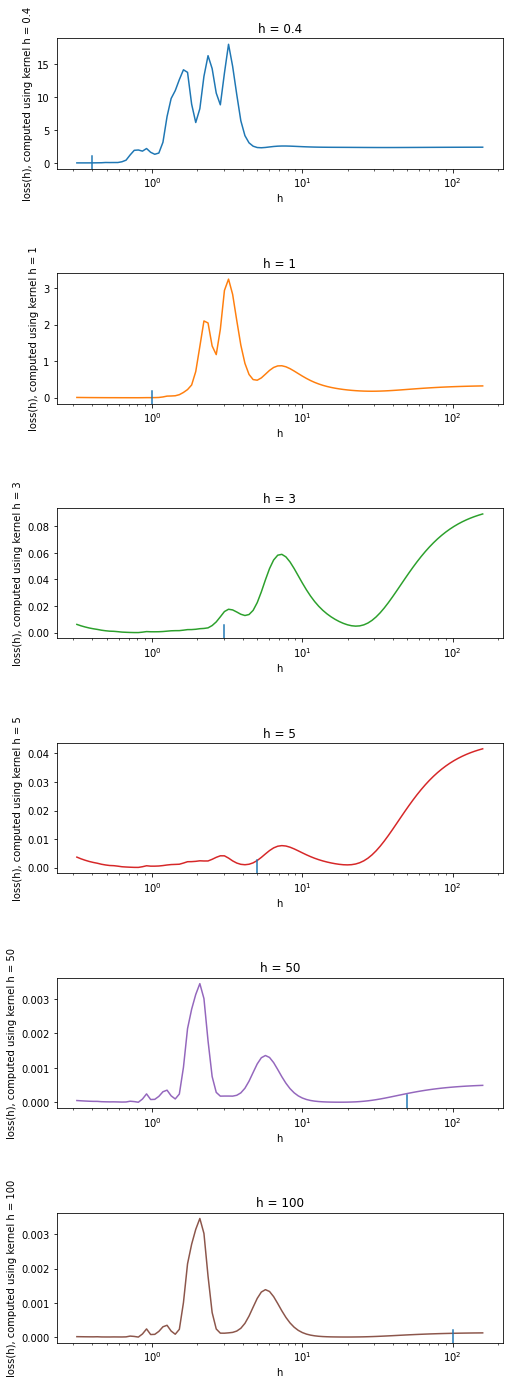

In [6]:
labels = [f"h = {h}" for h in ksd_grid]

makeplots(s.transpose(), bandwidth_grid, labels, xscale="log", style="")